<a href="https://colab.research.google.com/github/vparro/MLprobabilistico/blob/master/SIRDataDriven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações básicas

In [0]:
import pylab as pp
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy import optimize
from scipy.integrate import odeint

# Referências

https://www.apple.com/covid19/mobility

https://painel.covid19br.org

https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

https://cmdlinetips.com/2018/04/how-to-concatenate-arrays-in-numpy/

https://stackoverflow.com/questions/11278836/fitting-data-to-system-of-odes-using-python-via-scipy-numpy

# **Dados artificiais**

Uma prática interessante na análise de dados é testarmos se o algoritmo proposto e principalmente sua estrutura está consistente. Podemos então utilizar dados artificiais para avaliar se o processo de ajuste está estruturado corretamente.

In [0]:

# Lendo o arquivo de dados no formato 'filename.csv'  
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/PG_IMT/DadosEpidemia/SIRpd") 
# Preview das cinco primeiras linhas
data.head()

,S,I,R
0,499.000000,1.000000,0.000000
1,498.949042,1.040746,0.010213
2,498.896013,1.083146,0.020841
3,498.840830,1.127267,0.031903
4,498.783405,1.173179,0.043415


In [0]:
s_array = data[["S", "I", "R"]].to_numpy()
s_array[:,0:]
Sd = s_array[:,0]
Id = s_array[:,1]
Rd = s_array[:,2]

**Gerando ruído gaussiano**

In [0]:
Sdn = np.random.normal(0, np.mean(Sd)/10, len(Sd)) 
Idn = np.random.normal(0, np.mean(Id)/5, len(Sd)) 
Rdn = np.random.normal(0, np.mean(Rd)/10, len(Sd)) 

**Adicionando aos dados**

In [0]:
Sd = Sd + Sdn
Id = Id + Idn
Rd = Rd + Rdn

**Visualizando os dados**

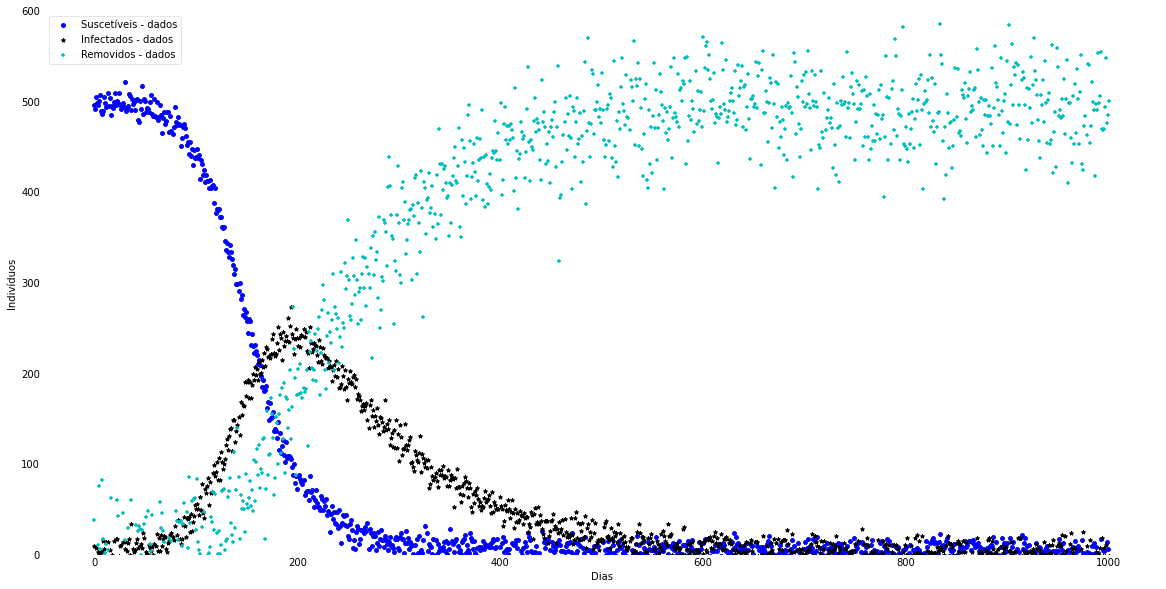

In [0]:
# Visualizando a evolução da Epidemia - S(t), I(t) e R(t)
t = np.linspace(0,len(Sd),len(Sd))
fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
plt.scatter(t,Sd, marker='o', color='b', label='Suscetíveis - dados', s=15)
plt.scatter(t,Id, marker='*', color='k', label='Infectados - dados', s=15)
plt.scatter(t,Rd, marker='+', color='c', label='Removidos - dados', s=15)
ax.set_xlabel('Dias')
ax.set_ylabel('Indivíduos')
ax.set_ylim(0,600)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

# **O problema**









O conjunto de equações diferenciais que caracteriza o modelo é descrito abaixo. No modelo $\beta - \text{representa a taxa de transmissão ou taxa efetiva de contato} $  e $r - \text{a taxa de remoção ou recuperação.}$ 


$$ \begin{split}
   \frac{dS(t)}{dt} & = -\beta S(t) I(t) \\
   \frac{dI(t)}{dt} & = \beta S(t) I(t) - rI(t)  \\
   \frac{dR(t)}{dt} & = r I(t)
   \end{split}$$

   Gostaríamos de identificar quais parâmetros $\beta$ e $r$ resultam num melhor ajuste do modelo para os dados de **S**,**I** e **R**

In [0]:
def SIRmodel(y, t, Beta,r):
    S, I, R = y
    Sdot = -(Beta * S * I)
    Idot = (Beta * S * I)  - r * I
    Rdot = r * I
    return Sdot, Idot, Rdot   

# Resolução da simulação - Escala temporal (dias)

# **Obtendo** $y_s(\theta,k) = [S \; I \: R]$



O trecho a seguir retorna os valores sintetizados $y_s(\theta,k) = [S \; I \: R]$ representa o dado sintetizado a partir de um modelo sintetizado para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. A partir de uma condição inicial $y_0$.



In [0]:
def SIRsim(y0,t,theta):
    Beta = theta[0]
    r = theta[1]
    ret = integrate.odeint(SIRmodel,y0,t,args=(Beta,r))
    S, I, R = ret.T
    return S, I, R

# **Condições inicias** - $y_0$ e $\theta_0$

In [0]:

# Tamanho da populção - N
N = 500

# Valores iniciais 
I0 = 1 
R0 = 0
S0 = N - I0

# Vetor de condições iniciais

y0 = S0, I0, R0

# Beta -  taxa de contato,
# r - taxa média de recuperação (in 1/dia).

theta0 = [1e-4,1e-2] # valores iniciais

# Definição do conjunto de equações diferencias não lineares que formam o modelo.

t = np.linspace(0, 1000, 1000)

# **Estimativa de parâmetros**

Para estimarmos os parâmetros do modelo $\mathbf{\beta}$ e $\mathbf{r}$, vamos utilizar  inicialmente o método de mínimos quadrados. Podemos então formular o problema a partir da Equação abaixo. Na Equação $y_m(k)$ representa o dado real em cada amostra $k$; $y_s(\theta,k)$ representa o **valor estimado** a partir da simulação do modelo para uma determinada amostra $k$ e $\theta$ representa o vetor ed parâmetros $\theta = [ \beta \; \; r]^T$. 

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

A equação formula a pergunta: quais os valores de $beta$ e $r$ que minizam o erro quadrático quando comparados com os dados reais.

In [0]:
def ErroQuadratico(Sd,Id,Rd,y0,t,theta0):
    """ function to pass to optimize.leastsq
        The routine will square and sum the values returned by 
        this function""" 
    [S,I,R] = SIRsim(y0,t,theta0)
    erroS = S - Sd
    erroI = I - Id
    erroR = R - Rd
    EQ = np.concatenate([erroI,erroR])
    return EQ

def objetivo(p):
    return ErroQuadratico(Sd,Id,Rd,y0,t,p)


# **Minimização da função custo**

In [0]:
(c,kvg) = optimize.leastsq(objetivo,theta0) 
print(c)


[9.99987874e-05 9.96826728e-03]


# **Visualização**

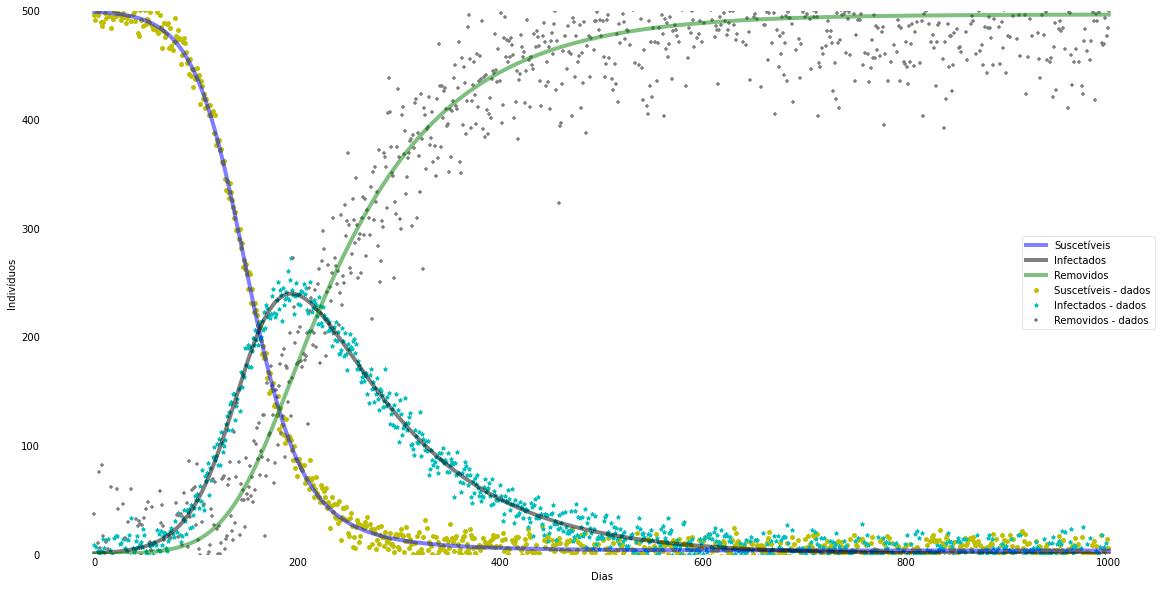

In [0]:

[Sa,Ia,Ra] = SIRsim(y0,t,c)
# Visualizando a evolução da Epidemia - S(t), I(t) e R(t)
fig = plt.figure(facecolor='w',figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, Sa, 'b', alpha=0.5, lw=4, label='Suscetíveis')
ax.plot(t, Ia, 'k', alpha=0.5, lw=4, label='Infectados')
ax.plot(t, Ra, 'g', alpha=0.5, lw=4, label='Removidos')
plt.scatter(t,Sd, marker='o', color='y', label='Suscetíveis - dados', s=15)
plt.scatter(t,Id, marker='*', color='c', label='Infectados - dados', s=15)
plt.scatter(t,Rd, marker='+', color='gray', label='Removidos - dados', s=15)
ax.set_xlabel('Dias')
ax.set_ylabel('Indivíduos')
ax.set_ylim(0,500)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()